# Satellite sea surface temperatures along the West Coast of the United States 
# during the 2014–2016 northeast Pacific marine heat wave

In 2016 we published a [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071039) on the heat wave in the ocean off the California coast

This analysis was the last time I used Matlab to process scientific data. To make Figure 1, here are the following steps:
- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. Once the anomalies were calculated, then I could start to do analyses and explore the data.
Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

In [1]:
pip install cartopy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

warnings.simplefilter("ignore")  # filter some warning messages
xr.set_options(display_style="html")  # display dataset nicely

### Set the space/time parameters
- Region for subsetting spatially and temporally (for climatology)
- 5 points for timeseries

In [3]:
xlat1, xlat2 = 33, 48
xlon1, xlon2 = (
    -132,
    -118,
)
date1, date2 = "2022-12-21", "2023-12-21"

blanco = {"name": "Cape Blanco", "lat": 42.837, "lon": -124.563}
mendo = {"name": "Cape Mendocino", "lat": 40.44, "lon": -124.408}
newport = {"name": "Newport", "lat": 45, "lon": -124.061}
# newport={'name':'Newport','lat':44.634,'lon':-124.061}
mont = {"name": "Monterey", "lat": 36.598, "lon": -121.8922}
sbarb = {"name": "Santa Barbara", "lat": 34.417, "lon": -119.700}

# Amazon Open Data Program [MUR SST](https://registry.opendata.aws/mur/)
NASA JPL MUR Level 4 SST dataset in [Zarr](https://zarr.readthedocs.io/en/stable/) format.\
There are two version of this data:\
- The zarr-v1/ directory contains a zarr store chunked (6443, 100, 100) along the dimensions (time, lat, lon).
- The zarr/ directory contains a zarr store chunked (5,1799,3600) along the dimensions (time, lat, lon).

What is chunking and why does it matter? Read [this](https://www.unidata.ucar.edu/blogs/developer/en/entry/chunking_data_why_it_matters).

In [5]:
file_aws = "https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1"
file_aws_time = "https://mur-sst.s3.us-west-2.amazonaws.com/zarr"

## Read MUR SST chunked for space/time

In [6]:
%%time
ds_sst = xr.open_zarr(file_aws, consolidated=True, engine='zarr')
ds_sst

TypeError: open_zarr() got unexpected keyword arguments engine

## Read MUR SST chunked for time series analysis

In [7]:
%%time
ds_sst_time = xr.open_zarr(file_aws_time, consolidated=True)

ds_sst_time

CPU times: user 1.1 s, sys: 206 ms, total: 1.31 s
Wall time: 2.77 s


<xarray.Dataset> Size: 104TB
Dimensions:           (time: 6443, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 52kB 2002-06-01T09:00:00 ... 2020...
Data variables:
    analysed_sst      (time, lat, lon) float64 33TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 33TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    mask              (time, lat, lon) int8 4TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 33TB dask.array<chunksize=(6443, 100, 100), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

# Subset all the data to just the West Coast region

In [8]:
subset = ds_sst.sel(lat=slice(xlat1, xlat2), lon=slice(xlon1, xlon2))

subset

NameError: name 'ds_sst' is not defined

# Just plot a random day to make sure it looks correct
- Should we use subset or subset time? Why?

In [ ]:
subset.analysed_sst[0, :, :].plot()

AttributeError: module 'matplotlib.pyplot' has no attribute 'coastlines'

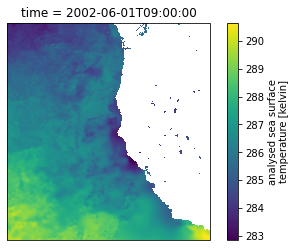

In [ ]:
# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

# Plot on a map
ax = plt.subplot(projection=crs)

subset.analysed_sst[0, :, :].plot(ax=ax, transform=crs)

ax.coastlines("10m", color="k")

ax.add_feature(cfeature.LAND, color="grey")

ax.add_feature(cfeature.STATES.with_scale("10m"))

# How big is this dataset?
- Because xarray uses lazy loading, we have access to this entire dataset but it only loads what it needs to for calculations

In [ ]:
nbytes_per_value = 4  # real 4-byte number
num_variables = 4
print("dims:", subset.dims)
print("shape:", subset.analysed_sst.shape)
print(
    "size of data:",
    np.prod(subset.analysed_sst.shape) * 1e-9 * nbytes_per_value * num_variables,
)
print("GB data = ", subset.nbytes * 1e-9)

# Caluculate the Monthly Sea Surface Temperature Anomalies

In [ ]:
sst_monthly = subset.resample(time="1MS").mean("time", keep_attrs=True, skipna=False)

climatology_mean_monthly = (
    sst_monthly.sel(time=slice(date1, date2))
    .groupby("time.month")
    .mean("time", keep_attrs=True, skipna=False)
)

sst_anomaly_monthly = (
    sst_monthly.groupby("time.month") - climatology_mean_monthly
)  # take out annual mean to remove trends

sst_anomaly_monthly

In [ ]:
sst_anomaly_monthly.analysed_sst.sel(time="2003-03-01", method="nearest").plot(
    vmin=-3, vmax=3, cmap="RdYlBu_r"
)

In [ ]:
sst_anomaly_monthly.analysed_sst.sel(time="2015-03-01", method="nearest").plot(
    vmin=-3, vmax=3, cmap="RdYlBu_r"
)

# Figure 3
- Switch to same data, but it is chunked differently
- it is optimized for timeseries rather than spatial analysis

In [ ]:
# change to deg C
ds_sst_time["analysed_sst"] = ds_sst_time["analysed_sst"] - 273.15 # transform units from Kelvin to  Celsius
ds_sst_time["analysed_sst"].attrs["units"] = "deg C"  # update units in metadata

In [ ]:
%%time
sst_newport_coast = (
    ds_sst_time.analysed_sst.sel(
        lat=newport["lat"], lon=newport["lon"] - 0.05, method="nearest"
    )
    .rolling(time=30, center=True)
    .mean()
    .load()
)
sst_newport_offshore = (
    ds_sst_time.analysed_sst.sel(
        lat=newport["lat"], lon=newport["lon"] - 10, method="nearest"
    )
    .rolling(time=30, center=True)
    .mean()
    .load()
)

In [ ]:
data = sst_newport_offshore
ystr = "SST$_{offshore}$ ($^\circ$C)"
maxval = data.sel(time=slice("2002", "2013")).groupby("time.dayofyear").max("time")
minval = data.sel(time=slice("2002", "2013")).groupby("time.dayofyear").min("time")
meanval = data.sel(time=slice("2002", "2013")).groupby("time.dayofyear").mean("time")
stdval = data.sel(time=slice("2002", "2013")).groupby("time.dayofyear").std("time")
plt.plot(data.sel(time="2014"), color="blue", zorder=-1, linewidth=2)
plt.plot(data.sel(time="2015"), color="red", zorder=-2, linewidth=2)
plt.plot(data.sel(time="2016"), color="green", zorder=-3, linewidth=2)
plt.fill_between(maxval.dayofyear, minval, maxval, color="gainsboro", zorder=-4)
plt.fill_between(
    maxval.dayofyear, meanval + stdval, meanval - stdval, color="darkgrey", zorder=1
)
plt.plot(meanval.dayofyear, meanval, color="black", zorder=2)
plt.xlim([0, 365]), plt.ylim([7, 23]), plt.ylabel(ystr), plt.xlabel("Day of Year")